<a href="https://colab.research.google.com/github/soumyaiitkgp/Prediction-and-modelling-of-wave-height/blob/master/BiLSTM_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.layers import Bidirectional, GlobalMaxPool1D

import os
import logging
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Mumbai'  # to set timezone; needed when running on cloud
time.tzset() 

Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving mehamn_data.csv to mehamn_data.csv


In [0]:
data = pd.read_csv('mehamn_data.csv', engine = 'python')
print(data.shape)
data.head()

(174581, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
0,0,1957,9,1,6,3.0,313,0.8,5.2,4.5,310,307,0.1,0.0,242,0.8,5.2,310
1,1,1957,9,1,9,2.0,321,0.8,5.2,4.7,310,318,0.1,0.0,242,0.8,5.2,310
2,2,1957,9,1,12,1.4,337,0.8,5.2,4.8,325,324,0.1,0.0,242,0.7,5.2,325
3,3,1957,9,1,15,2.2,44,0.7,5.2,4.9,325,326,0.1,0.0,242,0.7,5.2,325
4,4,1957,9,1,18,2.7,107,0.7,5.2,4.9,325,327,0.1,0.0,242,0.7,5.2,325


In [0]:
params = {
    "batch_size": 1440, #processing the information for 30 days at once
    "epochs": 100,
    "lr": 0.0001,
    "time_steps": 120 #prediction for 15 days
}

iter_changes = "dropout_layers_0.4_0.4"

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [0]:
for col in data.columns:
    print(col)

Num
YEAR
Month
Day
Hour
wind_WSP
wind_DIR
total_sea_HS
total_sea_TP
total_sea_TM
total_sea_DIRP
total_sea_DIRM
wind_sea_HS
wind_sea_TP
wind_sea_DIRP
swell_HS
swell_TP
swell_DIRP	


In [0]:
d = data

In [0]:
d_train,d_test = train_test_split(d,test_size=0.2, shuffle = False)
print(d_train.shape, d_test.shape)
d_train.head()

(139664, 18) (34917, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
0,0,1957,9,1,6,3.0,313,0.8,5.2,4.5,310,307,0.1,0.0,242,0.8,5.2,310
1,1,1957,9,1,9,2.0,321,0.8,5.2,4.7,310,318,0.1,0.0,242,0.8,5.2,310
2,2,1957,9,1,12,1.4,337,0.8,5.2,4.8,325,324,0.1,0.0,242,0.7,5.2,325
3,3,1957,9,1,15,2.2,44,0.7,5.2,4.9,325,326,0.1,0.0,242,0.7,5.2,325
4,4,1957,9,1,18,2.7,107,0.7,5.2,4.9,325,327,0.1,0.0,242,0.7,5.2,325


In [0]:
print(d_test.shape)
d_test.head()

(34917, 18)


,Num,YEAR,Month,Day,Hour,wind_WSP,wind_DIR,total_sea_HS,total_sea_TP,total_sea_TM,total_sea_DIRP,total_sea_DIRM,wind_sea_HS,wind_sea_TP,wind_sea_DIRP,swell_HS,swell_TP,swell_DIRP
139664,139664,2005,6,19,6,6.1,113,0.9,6.9,4.7,55,62,0.4,3.6,100,0.8,6.9,55
139665,139665,2005,6,19,9,4.4,107,0.9,6.9,5.0,55,58,0.3,3.2,115,0.9,6.9,55
139666,139666,2005,6,19,12,2.7,105,0.9,6.9,5.4,55,55,0.1,0.0,242,0.8,6.9,55
139667,139667,2005,6,19,15,0.2,293,0.8,6.9,5.5,55,54,0.1,0.0,242,0.8,6.9,55
139668,139668,2005,6,19,18,2.7,275,0.8,6.9,5.6,55,53,0.1,0.0,242,0.8,6.9,55


In [0]:
x_train = d_train
x_test = d_test
print(x_train.shape,x_test.shape)

(139664, 18) (34917, 18)


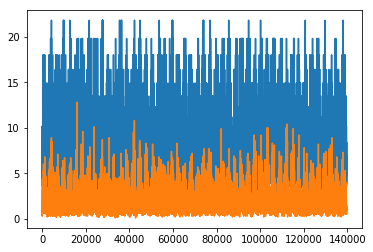

In [0]:
plt.figure()
plt.plot(x_train["total_sea_TP"])
plt.plot(x_train["total_sea_HS"])
plt.show()

In [0]:
#train_cols = ["Month","Day","Hour", "wind_WSP","wind_DIR","total_sea_TP","total_sea_DIRP","wind_sea_TP","wind_sea_DIRP","swell_TP","swell_DIRP"]
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(x_train)
X_test = min_max_scaler.fit_transform(x_test)

(139664, 18)


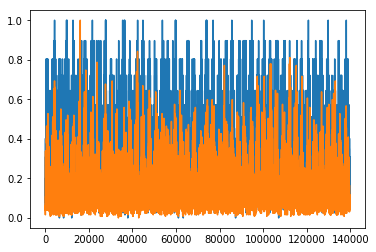

In [0]:
type(X_train)
print(X_train.shape)
plt.figure()
plt.plot(X_train[0:,8])
plt.plot(X_train[0:,7])
plt.show()

In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column, here it will be 9
    # total number of time-series samples would be len(mat) - TIME_STEPS
    #TIME_STEPS = 8 for one day
    #LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.
    #So till now we have a matrix of shape (3, 5), 3 being the time step and 5 being the number of features
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print(dim_0,mat.shape[0])
    for i in tqdm_notebook(range(dim_0)):
        #print(i)
        x[i] = mat[i:TIME_STEPS+i]
        #print(mat[TIME_STEPS+i, y_col_index])
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
x_t, y_t = build_timeseries(X_train, 9)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

139544 139664



length of time-series i/o (139544, 120, 18) (139544,)


In [0]:
x_temp, y_temp = build_timeseries(X_test, 9)
x_tt = trim_dataset(x_temp, BATCH_SIZE)
y_tt = trim_dataset(y_temp, BATCH_SIZE)
print(y_tt.shape)
print(x_tt.shape)
x_val, x_test_t = np.split(x_tt,2)
y_val, y_test_t = np.split(y_tt,2)
print(x_val.shape, x_test_t.shape)
print(y_val.shape, y_test_t.shape)
#x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
#y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

34797 34917



length of time-series i/o (34797, 120, 18) (34797,)
(34560,)
(34560, 120, 18)
(17280, 120, 18) (17280, 120, 18)
(17280,) (17280,)


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, batch_input_shape = (BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True, kernel_initializer='random_uniform'))
#lstm_model.add(Dropout(0.2)) 
print(0)
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
#lstm_model.add(Dropout(0.2)) 
print(1)
lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
#lstm_model.add(Dropout(0.2)) 
print(2)
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
#lstm_model.add(Dropout(0.2)) 
print(3)
lstm_model.add(Bidirectional(LSTM(64)))
print(4)
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

0
1
2
3
4


In [0]:
OUTPUT_PATH = "D:\Acads\Saud sir"
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=25, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))#, callbacks=[csv_logger])

Train on 138240 samples, validate on 17280 samples
Epoch 1/25
 - 238s - loss: 0.0208 - val_loss: 0.0210
Epoch 2/25
 - 232s - loss: 0.0135 - val_loss: 0.0235
Epoch 3/25
 - 232s - loss: 0.0115 - val_loss: 0.0204
Epoch 4/25
 - 232s - loss: 0.0099 - val_loss: 0.0162
Epoch 5/25
 - 232s - loss: 0.0085 - val_loss: 0.0133
Epoch 6/25
 - 232s - loss: 0.0075 - val_loss: 0.0117
Epoch 7/25
 - 232s - loss: 0.0066 - val_loss: 0.0097
Epoch 8/25
 - 232s - loss: 0.0057 - val_loss: 0.0078
Epoch 9/25
 - 232s - loss: 0.0050 - val_loss: 0.0069
Epoch 10/25
 - 232s - loss: 0.0044 - val_loss: 0.0061
Epoch 11/25
 - 232s - loss: 0.0039 - val_loss: 0.0053
Epoch 12/25
 - 232s - loss: 0.0034 - val_loss: 0.0048
Epoch 13/25
 - 232s - loss: 0.0031 - val_loss: 0.0044
Epoch 14/25
 - 232s - loss: 0.0028 - val_loss: 0.0040
Epoch 15/25
 - 232s - loss: 0.0026 - val_loss: 0.0038
Epoch 16/25
 - 232s - loss: 0.0025 - val_loss: 0.0038
Epoch 17/25
 - 232s - loss: 0.0024 - val_loss: 0.0038
Epoch 18/25
 - 232s - loss: 0.0023 - val

In [0]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
from sklearn.metrics import mean_squared_error
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0024024362600816745 (17280,) (17280,)
[0.33535674 0.30686733 0.2612558  0.24519888 0.28838432 0.26928136
 0.22992602 0.18750921 0.17704165 0.25273743 0.32346618 0.4108536
 0.44847664 0.46478656 0.34447283]
[0.29411765 0.28235294 0.28235294 0.28235294 0.28235294 0.23529412
 0.22352941 0.15294118 0.27058824 0.34117647 0.37647059 0.45882353
 0.49411765 0.29411765 0.28235294]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[5.750532  5.5083723 5.120674  4.9841905 5.351267  5.1888914 4.854371
 4.4938283 4.404854  5.0482683 5.6494627 6.392256  6.7120514 6.850686
 5.828019 ]
[5.4 5.3 5.3 5.3 5.3 4.9 4.8 4.2 5.2 5.8 6.1 6.8 7.1 5.4 5.3]


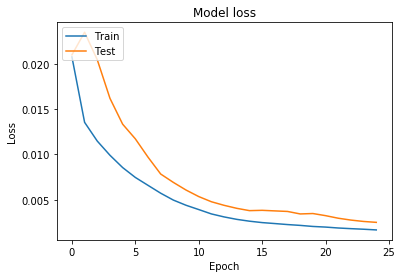

In [0]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

Error is 0.002402430072645644 (17280,) (17280,)
[0.3353814  0.30689088 0.26127782 0.24521872 0.28840446 0.26929665
 0.22993875 0.1875194  0.17705166 0.2527493  0.32347077 0.41084647
 0.44844815 0.46475482 0.34442884]
[0.29411765 0.28235294 0.28235294 0.28235294 0.28235294 0.23529412
 0.22352941 0.15294118 0.27058824 0.34117647 0.37647059 0.45882353
 0.49411765 0.29411765 0.28235294]
[4.208979  4.1522655 4.1500254 4.211589  4.3063364 4.4719725 4.6616836
 4.752862  4.793701  4.870891  5.132206  5.3275375 5.4160347 5.2656884
 5.300374  5.1025763 4.8100758 4.5788374 4.5108175 4.6606407 4.8610106
 5.019067  5.1627855 5.1745524 4.9887805 4.766514  4.6411734 4.7236557
 4.8940544 4.969775  4.9093623 4.7572126 4.6012955 4.4576545 4.3281083
 4.3319087 4.3386083 4.2579217 4.306548  4.4249897 4.550784  4.6416626
 4.6548862 4.675537  4.6569114 4.8101816 5.071326  5.4566894 5.825255
 6.1776414 6.4704494 6.440233  6.158595  5.746048  5.2657747 4.9511657
 4.931218  5.0839877 5.3380284 5.5698404 5.6502

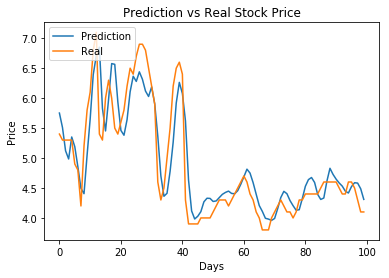

batch_size =  1440 timesteps = 120 lr = 0.001 optimizer = Adam No of LSTM layers =2 Dropout=0.4 stateful=True 
Actual error is 0.17357558117316557 (17280,) (17280,)


In [0]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
#y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[9]) + min_max_scaler.data_min_[9] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[100:200])
print(y_test_t_org[100:200])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
print("batch_size = ",BATCH_SIZE ,"timesteps =",TIME_STEPS , "lr = 0.001","optimizer = Adam", "No of LSTM layers =2","Dropout=0.4","stateful=True ")
error = mean_squared_error(y_test_t_org, y_pred_org)
print("Actual error is", error, y_pred_org.shape, y_test_t_org.shape)

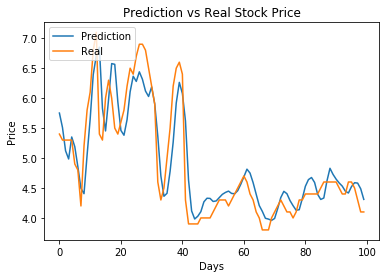

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

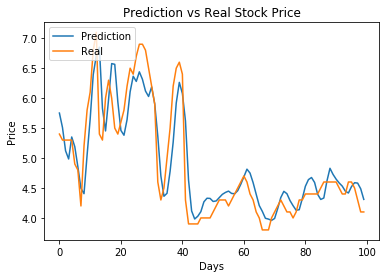

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_test_t_org)
#plt.plot(y_pred_org)

plt.plot(y_pred_org[0:100])
plt.plot(y_test_t_org[0:100])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

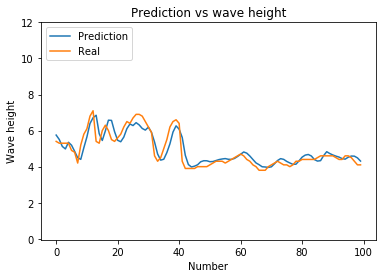

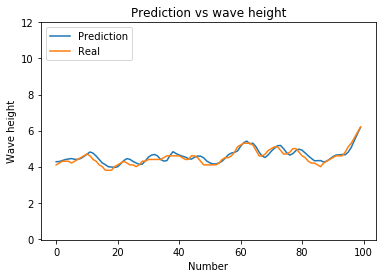

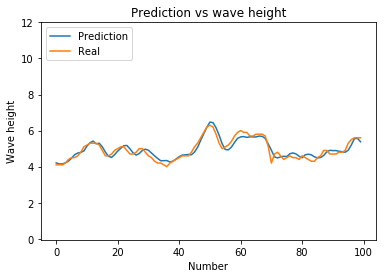

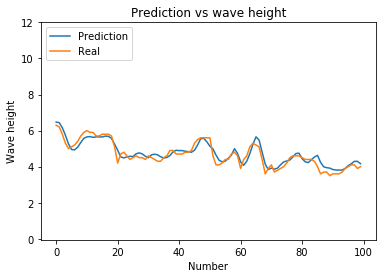

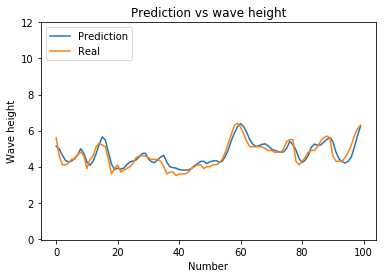

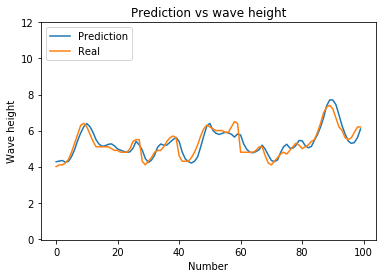

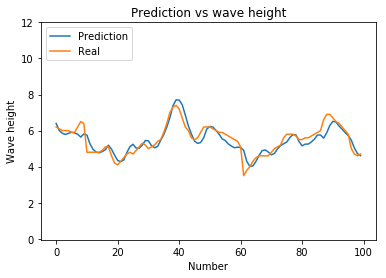

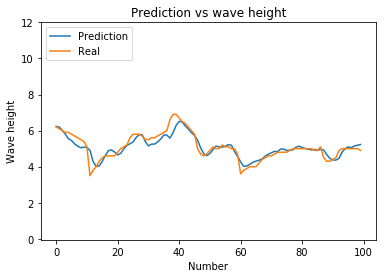

In [0]:
for i in range(175):
    plt.figure()
    plt.plot()
    plt.ylim(top = 12)
    plt.plot(y_pred_org[i*100:i*100 + 100])
    plt.plot(y_test_t_org[i*100:i*100 + 100])
    plt.plot()
    plt.title('Prediction vs wave height')
    plt.ylabel('Wave height')
    plt.xlabel('Number')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    #from google.colab import files
    from google.colab import files
    plt.savefig('Plot'+ str(i)+'0'+'(BiLSTM_4.1)'+'.png')
    files.download('Plot'+ str(i)+'0'+'(BiLSTM_4.1)'+'.png')
    plt.show()
    
    plt.figure()
    plt.plot()
    plt.ylim(top = 12)
    plt.plot(y_pred_org[50+i*100:i*100 + 150])
    plt.plot(y_test_t_org[50+i*100:i*100 + 150])
    plt.plot()
    plt.title('Prediction vs wave height')
    plt.ylabel('Wave height')
    plt.xlabel('Number')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    #from google.colab import files
    from google.colab import files
    plt.savefig('Plot'+ str(i)+'1'+'(BiLSTM_4.1)'+'.png')
    files.download('Plot'+ str(i)+'1'+'(BiLSTM_4.1)'+'.png')
    #plt.savefig('Plot'+ str(i)+'1'+'(LSTM_4.1)'+'.png')
    #files.download('Plot'+ str(i)+'0'+'(LSTM_4.1)'+'.png')
    plt.show()

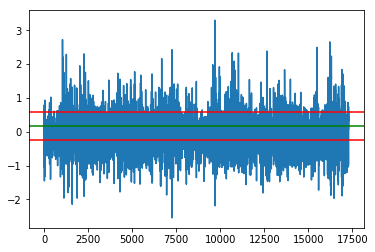

In [0]:





plt.figure()
plt.plot(y_test_t_org - y_pred_org)
plt.axhline(y=error + np.std(y_test_t_org - y_pred_org) ,color = 'Red')
plt.axhline(y=error - np.std(y_test_t_org - y_pred_org) ,color = 'Red')
plt.axhline(y=error,color = 'g')
plt.show()

In [0]:
print(max(y_test_t_org - y_pred_org))
print(min(y_test_t_org - y_pred_org))
print(type(y_test_t_org - y_pred_org))
print(np.mean(y_test_t_org - y_pred_org))
print(np.std(y_test_t_org - y_pred_org))
sklearn.metrics.mean_absolute_error(y_test_t_org,y_pred_org)

3.296848487854003
-2.5454067230224613
<class 'numpy.ndarray'>
-0.03799554476307515
0.4148878399656017


0.30850030692363223

Max error: 03.296848487854003
Min error: -2.5454067230224613
Average: -0.03799554476307515
Standard deviation:0.4148878399656017
Error is 0.17357558117316557
Mean absolute error: 0.30850030692363223